# Employee Income Prediction ML Application

This machine learning project is designed to predict whether an individual's income exceeds **$50K USD per year** based on demographic and work-related attributes. The model is trained on the widely used **UCI Adult Income Dataset** and provides predictions via an intuitive web interface using **Streamlit**.

## Project Overview

- Problem Statement: Predict the income of individuals (`<=50K` or `>50K`) from structured census and demographic data.
- Dataset: UCI Adult Income Census dataset (45K+ instances); includes features like age, education, occupation, capital gains/losses, hours worked per week, etc.
- Target Variable: `income` (binary: `<=50K`, `>50K`)

## Features

Train & Compare Multiple ML Models:
- Logistic Regression
- Decision Tree
- Random Forest
- Gradient Boosting
- XGBoost
- Linear Regression (for reference)
- Polynomial Regression

Key Functionality:
- Dynamic feature selection via checkboxes
- Model selection to compare performance and predictions
- Automated model evaluation and ranking
- Hyperparameter tuning for selected models (optional)
- Live prediction interface with real-time form inputs
- Optimized training and preprocessing pipeline using `scikit-learn` Pipelines


### DataPreprocessor: A Data Preparation Pipeline for the UCI Adult Dataset
This notebook provides a reusable DataPreprocessor class for working with the UCI Adult dataset. It covers downloading, loading, cleaning, encoding, scaling, and preparing data for machine learning tasks.

**Key Features**
- **Automated Download:** Fetches the Adult dataset from the UCI ML repository if not present locally.
- **Clean Data:** Handles missing values and removes incomplete records.
- **Feature Encoding:** Applies label encoding to categorical features and the target.
- **Feature Scaling:** Standardizes numerical features.
- **Train-Test Split:** Prepares data for modeling with stratified sampling.
- **Single Input Preprocessing:** Allows easy preprocessing of new data samples for prediction.

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import urllib.request
import os

class DataPreprocessor:
    def __init__(self):
        self.label_encoders = {}
        self.scaler = StandardScaler()
        self.feature_names = []

    def download_data(self, data_path='data/'):
        """Download the Adult dataset from UCI repository"""
        if not os.path.exists(data_path):
            os.makedirs(data_path)

        url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'
        filename = os.path.join(data_path, 'adult.data')

        if not os.path.exists(filename):
            print("Downloading Adult dataset...")
            urllib.request.urlretrieve(url, filename)
            print(f"Dataset downloaded to {filename}")
        else:
            print(f"Dataset already exists at {filename}")

        return filename

    def load_data(self, filepath):
        """Load and return the dataset with proper column names"""
        column_names = [
            'age', 'workclass', 'fnlwgt', 'education', 'educational_num',
            'marital_status', 'occupation', 'relationship', 'race', 'gender',
            'capital_gain', 'capital_loss', 'hours_per_week', 'native_country', 'income'
        ]

        df = pd.read_csv(filepath, names=column_names, skipinitialspace=True)
        return df

    def clean_data(self, df):
        """Clean the dataset by handling missing values and inconsistencies"""
        # Replace '?' with NaN
        df = df.replace('?', np.nan)

        # Remove rows with missing values
        df = df.dropna()

        # Reset index
        df = df.reset_index(drop=True)

        print(f"Data shape after cleaning: {df.shape}")
        print(f"Missing values: {df.isnull().sum().sum()}")

        return df

    def encode_features(self, df, fit=True):
        """Encode categorical variables"""
        df_encoded = df.copy()

        categorical_columns = ['workclass', 'education', 'marital_status', 'occupation',
                             'relationship', 'race', 'gender', 'native_country']

        for col in categorical_columns:
            if col in df_encoded.columns:
                if fit:
                    le = LabelEncoder()
                    df_encoded[col] = le.fit_transform(df_encoded[col])
                    self.label_encoders[col] = le
                else:
                    if col in self.label_encoders:
                        # Handle unseen categories
                        le = self.label_encoders[col]
                        df_encoded[col] = df_encoded[col].map(lambda x: le.transform([x])[0] 
                                                            if x in le.classes_ else -1)

        # Encode target variable
        if 'income' in df_encoded.columns:
            if fit:
                le_target = LabelEncoder()
                df_encoded['income'] = le_target.fit_transform(df_encoded['income'])
                self.label_encoders['income'] = le_target
            else:
                le_target = self.label_encoders['income']
                df_encoded['income'] = le_target.transform(df_encoded['income'])

        return df_encoded

    def scale_features(self, X_train, X_test=None, fit=True):
        """Scale numerical features"""
        numerical_columns = ['age', 'fnlwgt', 'educational_num', 'capital_gain', 
                           'capital_loss', 'hours_per_week']

        X_train_scaled = X_train.copy()

        if fit:
            X_train_scaled[numerical_columns] = self.scaler.fit_transform(X_train[numerical_columns])
        else:
            X_train_scaled[numerical_columns] = self.scaler.transform(X_train[numerical_columns])

        if X_test is not None:
            X_test_scaled = X_test.copy()
            X_test_scaled[numerical_columns] = self.scaler.transform(X_test[numerical_columns])
            return X_train_scaled, X_test_scaled

        return X_train_scaled

    def prepare_data(self, test_size=0.2, random_state=42):
        """Complete data preparation pipeline"""
        # Download and load data
        filepath = self.download_data()
        df = self.load_data(filepath)

        print(f"Original data shape: {df.shape}")
        print(f"\nTarget distribution:\n{df['income'].value_counts()}")

        # Clean data
        df_clean = self.clean_data(df)

        # Encode categorical variables
        df_encoded = self.encode_features(df_clean, fit=True)

        # Separate features and target
        X = df_encoded.drop('income', axis=1)
        y = df_encoded['income']

        # Store feature names
        self.feature_names = X.columns.tolist()

        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=random_state, stratify=y
        )

        # Scale features
        X_train_scaled, X_test_scaled = self.scale_features(X_train, X_test, fit=True)

        print(f"\nTraining set shape: {X_train_scaled.shape}")
        print(f"Test set shape: {X_test_scaled.shape}")

        return X_train_scaled, X_test_scaled, y_train, y_test, df_clean

    def preprocess_single_input(self, input_data):
        """Preprocess a single input for prediction"""
        df_input = pd.DataFrame([input_data])

        # Encode categorical variables
        df_encoded = self.encode_features(df_input, fit=False)

        # Scale numerical features
        df_scaled = self.scale_features(df_encoded, fit=False)

        return df_scaled


## Employee Income Prediction - Main Training Script

This script is the primary entry point for building a machine learning pipeline to predict employee income using the UCI Adult Income dataset. It orchestrates the entire process, from data preprocessing to model training, evaluation, and saving the final models.

---

## Overview
The pipeline includes the following key steps:

### Data Preprocessing
- Loads and cleans the UCI Adult dataset.
- Encodes categorical features and scales numerical columns.
- Splits the data into training and test sets.
- Generates an EDA (Exploratory Data Analysis) report.

### Model Training
- Trains multiple classification models.
- Compares model performance using metrics like **accuracy** and **ROC-AUC**.
- Displays a summary of results.

### Hyperparameter Tuning *(Optional)*
- Conducts hyperparameter tuning for selected models (e.g., **Random Forest**, **XGBoost**).
- Evaluates and compares tuned model performance.
- Updates best model if tuning yields improvement.

### Feature Importance
- Analyzes and plots feature importances for models that support it.
- Outputs the top 10 most important features contributing to income prediction.

### Final Model Evaluation
- Evaluates the performance of the final (best) model on the test set.
- Displays key metrics like **accuracy** and **ROC-AUC**.

### Saving Results
- Saves the best model to disk.
- Persists the preprocessing pipeline using `joblib`.
- Stores model metadata, including evaluation metrics and selected features, in a `JSON` file.


### Key Modules Used
- `data_preprocessing`: Handles data loading, cleaning, encoding, and scaling.
- `model_training`: Trains, evaluates, and tunes various ML models.
- `utils`: Utility functions for EDA report generation and plotting.



Starting Employee Income Prediction ML Pipeline

STEP 1: Data Preprocessing
------------------------------
Dataset already exists at data/adult.data
Original data shape: (32561, 15)

Target distribution:
income
<=50K    24720
>50K      7841
Name: count, dtype: int64
Data shape after cleaning: (30162, 15)
Missing values: 0

Training set shape: (24129, 14)
Test set shape: (6033, 14)

📈 Dataset Overview:
Shape: (30162, 15)
Features: ['age', 'workclass', 'fnlwgt', 'education', 'educational_num', 'marital_status', 'occupation', 'relationship', 'race', 'gender', 'capital_gain', 'capital_loss', 'hours_per_week', 'native_country']

STEP 2: Model Training
------------------------------
Training models...

Training Logistic Regression...


c:\Users\Ansh\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\Ansh\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-

Accuracy: 0.8163
ROC-AUC: 0.8486
CV Score: 0.8202 (+/- 0.0090)

Training Decision Tree...
Accuracy: 0.8061
ROC-AUC: 0.7398
CV Score: 0.8069 (+/- 0.0094)

Training Random Forest...
Accuracy: 0.8540
ROC-AUC: 0.9025
CV Score: 0.8542 (+/- 0.0073)

Training Gradient Boosting...
Accuracy: 0.8589
ROC-AUC: 0.9160
CV Score: 0.8620 (+/- 0.0066)

Training XGBoost...
Accuracy: 0.8616
ROC-AUC: 0.9204
CV Score: 0.8675 (+/- 0.0073)

🏆 Best Model: XGBoost (Accuracy: 0.8616)

Model Performance Summary:
              Model  Accuracy  ROC-AUC  CV Mean  CV Std
            XGBoost    0.8616   0.9204   0.8675  0.0037
  Gradient Boosting    0.8589   0.9160   0.8620  0.0033
      Random Forest    0.8540   0.9025   0.8542  0.0037
Logistic Regression    0.8163   0.8486   0.8202  0.0045
      Decision Tree    0.8061   0.7398   0.8069  0.0047

STEP 3: Hyperparameter Tuning
----------------------------------------
Tuning XGBoost...

Performing hyperparameter tuning for XGBoost...
Fitting 3 folds for each of 16 can

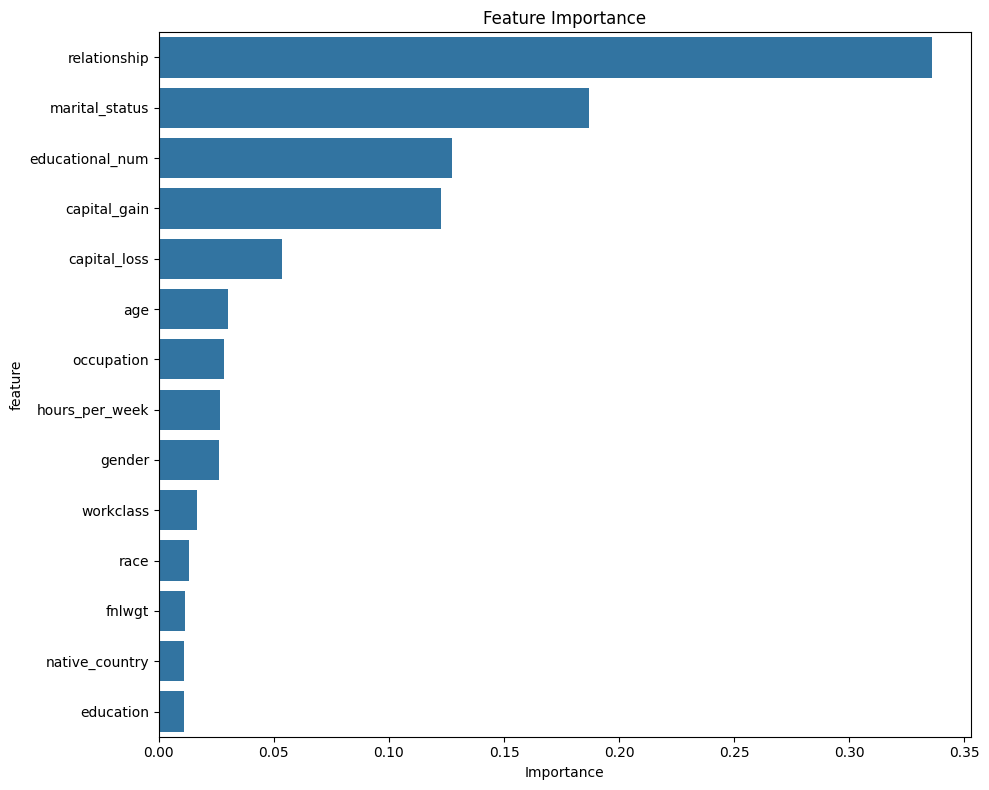


Top 10 Most Important Features:
        feature  importance
   relationship    0.335891
 marital_status    0.186799
educational_num    0.127358
   capital_gain    0.122512
   capital_loss    0.053414
            age    0.030096
     occupation    0.028328
 hours_per_week    0.026587
         gender    0.026236
      workclass    0.016496

STEP 5: Final Model Evaluation
----------------------------------------

Detailed Evaluation for XGBoost

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.94      0.91      4531
           1       0.77      0.65      0.71      1502

    accuracy                           0.87      6033
   macro avg       0.83      0.79      0.81      6033
weighted avg       0.86      0.87      0.86      6033


Confusion Matrix:
[[4244  287]
 [ 527  975]]

STEP 6: Saving Models
------------------------------
Model saved to models/xgboost_model.pkl
Preprocessor saved to models/preprocessor.pkl
Model metadata s

In [ ]:
import sys
import os
import joblib
from data_preprocessing import DataPreprocessor
from model_training import ModelTrainer
from utils import generate_eda_report, create_model_comparison_chart
import pandas as pd

def main():
    """Main training pipeline"""
    print("Starting Employee Income Prediction ML Pipeline")
    print("="*60)

    # Step 1: Data Preprocessing
    print("\nSTEP 1: Data Preprocessing")
    print("-" * 30)
    preprocessor = DataPreprocessor()
    X_train, X_test, y_train, y_test, df_clean = preprocessor.prepare_data()

    # Generate EDA report
    eda_report = generate_eda_report(df_clean)
    print(f"\nDataset Overview:")
    print(f"Shape: {eda_report['shape']}")
    print(f"Features: {list(X_train.columns)}")

    # Step 2: Model Training
    print("\nSTEP 2: Model Training")
    print("-" * 30)
    trainer = ModelTrainer()
    trainer.train_models(X_train, y_train, X_test, y_test)

    # Display model summary
    summary_df = trainer.get_model_summary()

    # Step 3: Hyperparameter Tuning (Optional)
    print("\nSTEP 3: Hyperparameter Tuning")
    print("-" * 40)

    # Tune the best performing model
    if trainer.best_model_name in ['Random Forest', 'XGBoost']:
        print(f"Tuning {trainer.best_model_name}...")
        tuned_model = trainer.hyperparameter_tuning(X_train, y_train, trainer.best_model_name)

        # Evaluate tuned model
        tuned_results = trainer.evaluate_model(tuned_model, X_test, y_test, f"Tuned {trainer.best_model_name}")
        print(f"\nTuned model accuracy: {tuned_results['accuracy']:.4f}")

        # Update best model if tuned version is better
        if tuned_results['accuracy'] > trainer.model_results[trainer.best_model_name]['accuracy']:
            trainer.best_model = tuned_model
            print("Tuned model performs better. Updated best model.")
    else:
        print(f"Hyperparameter tuning skipped for {trainer.best_model_name}")

    # Step 4: Feature Importance Analysis
    print("\nSTEP 4: Feature Importance Analysis")
    print("-" * 40)
    if hasattr(trainer.best_model, 'feature_importances_'):
        importance_df = trainer.plot_feature_importance(trainer.best_model, preprocessor.feature_names)
        print("\nTop 10 Most Important Features:")
        print(importance_df.head(10).to_string(index=False))

    # Step 5: Final Evaluation
    print("\nSTEP 5: Final Model Evaluation")
    print("-" * 40)
    final_results = trainer.evaluate_model(trainer.best_model, X_test, y_test, trainer.best_model_name)

    # Step 6: Save Models and Preprocessor
    print("\nSTEP 6: Saving Models")
    print("-" * 30)

    # Create models directory
    os.makedirs('models', exist_ok=True)

    # Save best model
    trainer.save_model(trainer.best_model, trainer.best_model_name)

    # Save preprocessor
    joblib.dump(preprocessor, 'models/preprocessor.pkl')
    print("Preprocessor saved to models/preprocessor.pkl")

    # Save model metadata
    metadata = {
        'best_model_name': trainer.best_model_name,
        'best_accuracy': trainer.model_results[trainer.best_model_name]['accuracy'],
        'feature_names': preprocessor.feature_names,
        'model_results': {k: {
            'accuracy': v['accuracy'],
            'roc_auc': v['roc_auc'],
            'cv_mean': v['cv_mean']
        } for k, v in trainer.model_results.items()}
    }

    import json
    with open('models/model_metadata.json', 'w') as f:
        json.dump(metadata, f, indent=2)
    print("Model metadata saved to models/model_metadata.json")

    # Final Summary
    print("\nTRAINING COMPLETED SUCCESSFULLY!")
    print("="*50)
    print(f"Best Model: {trainer.best_model_name}")
    print(f"Test Accuracy: {trainer.model_results[trainer.best_model_name]['accuracy']:.4f}")
    print(f"ROC-AUC Score: {trainer.model_results[trainer.best_model_name]['roc_auc']:.4f}")
    print("\nFiles created:")
    print("- models/preprocessor.pkl")
    print(f"- models/{trainer.best_model_name.lower().replace(' ', '_')}_model.pkl")
    print("- models/model_metadata.json")
    print("\nReady for deployment!")

if __name__ == "__main__":
    main()



---

## Overview: Visualization Utilities for Income Prediction

This module provides essential visualization tools designed for evaluating and interpreting machine learning models used in income classification tasks (e.g., predicting whether an individual's income is `<=50K` or `>50K`).

## What This Code Does

The script includes the following key functionalities:

### 1. Confusion Matrix Plot
- **Purpose**: Visualize model performance by comparing actual vs. predicted labels.
- **Tool Used**: Seaborn heatmap.
- **Function**: `plot_confusion_matrix(y_true, y_pred)`

### 2. Feature Distribution Plot
- **Purpose**: Explore how a specific feature is distributed overall and across income classes.
- **Functionality**:
  - For **categorical** features: bar chart + stacked bar by income.
  - For **numerical** features: histogram + box plot by income.
- **Function**: `plot_feature_distribution(df, feature)`

### 3. Model Performance Comparison Chart
- **Purpose**: Compare multiple machine learning models based on Accuracy and ROC-AUC.
- **Tool Used**: Plotly Interactive Bar Chart.
- **Function**: `create_model_comparison_chart(model_results)`

## Additional Info
- Each function includes a demo call using randomly generated data.
- All plots are displayed using `.show()` to ensure visible output when the script is run.
- Ideal for use in notebooks, scripts, or dashboards (e.g., Streamlit).



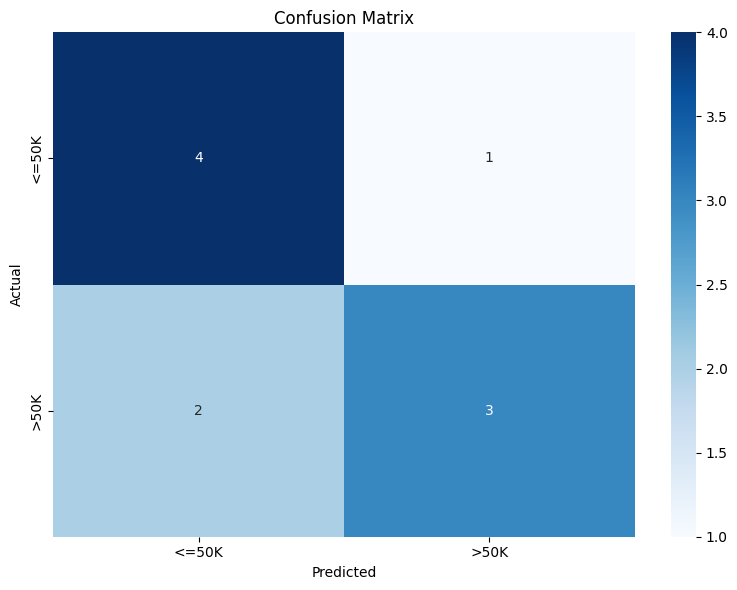

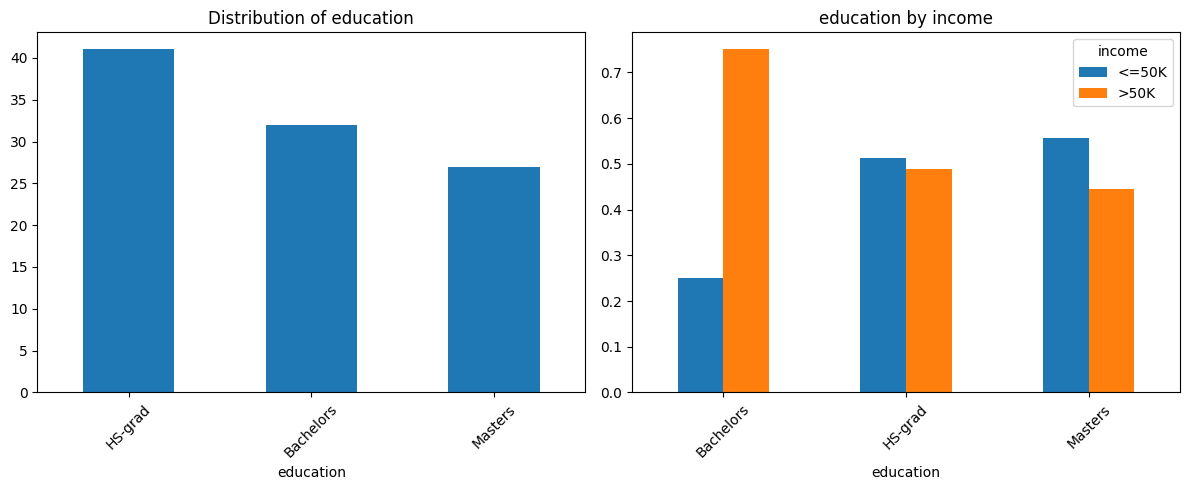

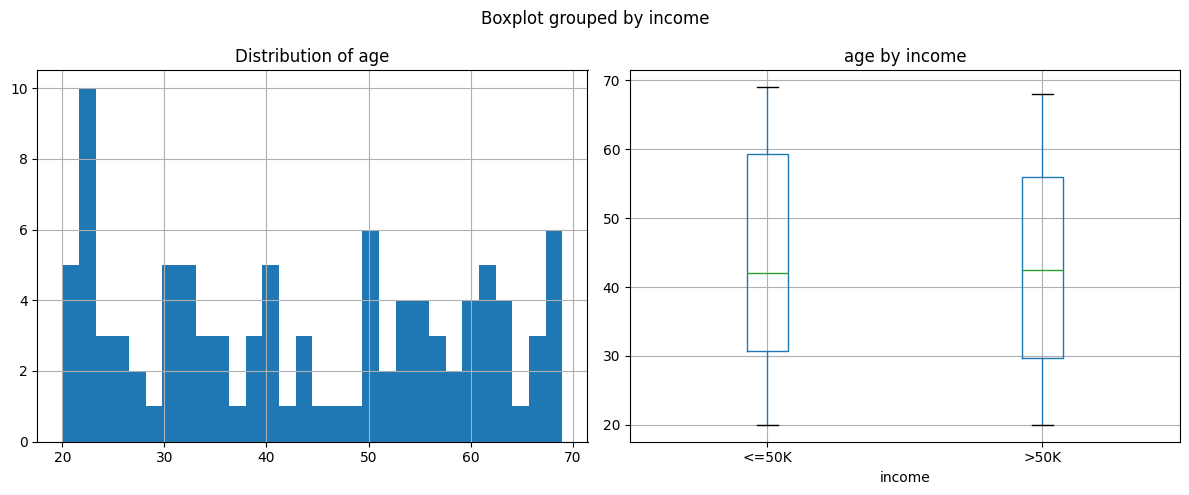

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import plotly.graph_objects as go

def plot_confusion_matrix(y_true, y_pred, labels=['<=50K', '>50K'], title='Confusion Matrix'):
    """Plot confusion matrix using seaborn"""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

def plot_feature_distribution(df, feature, target='income', figsize=(12, 5)):
    """Plot feature distribution by target variable"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    if df[feature].dtype == 'object':
        df[feature].value_counts().plot(kind='bar', ax=ax1)
        ax1.set_title(f'Distribution of {feature}')
        ax1.tick_params(axis='x', rotation=45)
        pd.crosstab(df[feature], df[target], normalize='index').plot(kind='bar', ax=ax2)
        ax2.set_title(f'{feature} by {target}')
        ax2.tick_params(axis='x', rotation=45)
    else:
        df[feature].hist(bins=30, ax=ax1)
        ax1.set_title(f'Distribution of {feature}')
        df.boxplot(column=feature, by=target, ax=ax2)
        ax2.set_title(f'{feature} by {target}')
    plt.tight_layout()
    plt.show()

def create_model_comparison_chart(model_results):
    """Create interactive comparison chart for model performance"""
    models = list(model_results.keys())
    accuracies = [model_results[model]['accuracy'] for model in models]
    roc_aucs = [model_results[model]['roc_auc'] for model in models]
    fig = go.Figure(data=[
        go.Bar(name='Accuracy', x=models, y=accuracies, marker_color='lightblue'),
        go.Bar(name='ROC-AUC', x=models, y=roc_aucs, marker_color='lightcoral')
    ])
    fig.update_layout(
        title='Model Performance Comparison',
        xaxis_title='Models',
        yaxis_title='Score',
        barmode='group',
        height=500
    )
    fig.show()

# ==== Demonstration of Outputs ====

# Confusion Matrix Example
y_true = [0, 0, 1, 1, 0, 1, 0, 1, 1, 0]  # Ground truth
y_pred = [0, 1, 1, 1, 0, 0, 0, 1, 0, 0]  # Predictions
plot_confusion_matrix(y_true, y_pred)

# Feature Distribution Example
np.random.seed(0)
sample_df = pd.DataFrame({
    'income': np.random.choice(['<=50K', '>50K'], size=100),
    'age': np.random.randint(20, 70, size=100),
    'education': np.random.choice(['Bachelors', 'HS-grad', 'Masters'], size=100)
})
plot_feature_distribution(sample_df, 'education')
plot_feature_distribution(sample_df, 'age')

# Model Comparison Chart Example
sample_results = {
    'Logistic Regression': {'accuracy': 0.82, 'roc_auc': 0.88},
    'Random Forest': {'accuracy': 0.87, 'roc_auc': 0.91},
    'XGBoost': {'accuracy': 0.89, 'roc_auc': 0.93}
}
create_model_comparison_chart(sample_results)
